# Linrary Imports

In [173]:
import os
import tarfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import regex as re
import emoji
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.metrics import precision_recall_curve,roc_auc_score,roc_curve
from sklearn.metrics import confusion_matrix,classification_report

from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold

import optuna
from optuna.visualization import plot_optimization_history, plot_parallel_coordinate, plot_slice, plot_contour, plot_param_importances
import warnings 
warnings.filterwarnings("ignore")

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# Extracting Files

In [ ]:
with tarfile.open("Files/20021204_hard_ham.tar.bz2") as tar:
    tar.extractall(path="Files/data/")

In [ ]:
with tarfile.open("Files/20021204_spam.tar.bz2") as tar:
    tar.extractall(path="Files/data/")

# Text Extractions

In [ ]:
def func(folder,label):
    emails=[]
    for file_name in os.listdir(folder):
        file_path=os.path.join(folder,file_name)
        if os.path.isfile(file_path):
            with open(file_path,"r",encoding="latin1") as f:
                emails.append((f.read(),label))
    return emails
ham=func("Files/data/hard_ham/","ham")
spam=func("Files/data/spam/","spam")

In [ ]:
data=ham+spam

In [ ]:
data=np.array(data)
len(data)

750

# Data cleaning

In [ ]:
X,Y=data[:,0],data[:,1]

In [ ]:
stem=PorterStemmer()
stop_words=set(stopwords.words("english"))

def data_cleaning(text):
    text=text.lower() #lowercase
    text=re.sub(r'<[^>]+>', ' ', text)  # remove headers
    text=re.sub(r"http\S+|www\S+","URL",text)   # change website to URL
    text=re.sub(r"\d","NUMBERS",text)   # removenumbers
    text = re.sub(r'[^a-zA-Z]', ' ', text)  # remove punch
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra space

    text=emoji.demojize(text)

    filtered_text=[]
    for word in text.split(" "):
        if word in stop_words:
            continue
        filtered_text.append(stem.stem(word))
    return " ".join(filtered_text)

X=[data_cleaning(text) for text in X]

# Splitting the Data

In [ ]:
Y=np.where(Y=="ham",0,1)

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.1,stratify=Y,random_state=42,shuffle=True)

# Evaluate Fucntion

In [ ]:
def evaluator(model,feature,target):
    
    predictions=cross_val_predict(model,feature,target,cv=2,method="predict")
    score=cross_val_predict(model,feature,target,cv=2,method="predict_proba")[:,1]
    
    Dict={"Acc":None,"Prec":None,"Rec":None,"F1":None,"AUC":None}
    Dict["Acc"]=round(accuracy_score(target,predictions)*100,2)
    Dict["Prec"]=round(precision_score(target,predictions)*100,2)
    Dict["Rec"]=round(recall_score(target,predictions)*100,2)
    Dict["F1"]=round(f1_score(target,predictions)*100,2)
    cnf_mat=confusion_matrix(target,predictions)
    clf_report=classification_report(target,predictions)
    Dict["AUC"]=round(roc_auc_score(target,score)*100,2)
    
    Data=pd.DataFrame(Dict,index=[model.__class__.__name__])

    fig,ax=plt.subplots(2,2,figsize=(20,15))

    prec,rec,thres=precision_recall_curve(target,score)
    fpr,tpr,threshols=roc_curve(target,score)

    ax[0][0].plot(prec,rec,color="red",label="Curve")
    ax[0][0].set_title("Precision Recall Curve")
    ax[0][0].set_xlabel("Precision")
    ax[0][0].set_ylabel("Recall")
    ax[0][0].legend()

    ax[0][1].plot(thres,prec[:-1],label="Precision",color="red")
    ax[0][1].plot(thres,rec[:-1],label="Recall",color="blue")
    ax[0][1].set_title("Precision Recall Trade Off Curve")
    ax[0][1].set_xlabel("Thresholds")
    ax[0][1].set_ylabel("Values")
    ax[0][1].legend()
    

    ax[1][0].plot(fpr,tpr,label=f"ROC {Dict["AUC"]}")
    ax[1][0].set_title("ROC_CURVE")
    ax[1][0].set_xlabel("False Positive Rate")
    ax[1][0].set_ylabel("True Positive Rate")
    ax[1][0].legend()
    

    sns.heatmap(cnf_mat,annot=True,fmt="0.1f",linewidths=0.2,linecolor="black",cmap="Blues",ax=ax[1][1])

    plt.tight_layout()
    plt.show()
    print(clf_report)
    return Data

# Data Vectorizers

In [ ]:
vectorizer=TfidfVectorizer()
vectorizer.fit(X_train)

TfidfVectorizer()

In [ ]:
print("Lenght of vocab : ",len(vectorizer.vocabulary_))

Lenght of vocab :  46381


In [ ]:
X_train_prep=vectorizer.transform(X_train)
X_test_prep=vectorizer.transform(X_test)

# Model Selection

In [ ]:
models=[SGDClassifier(loss="log_loss"),RandomForestClassifier(),XGBClassifier()]
result=[]

---MODEL TRAINING STARTED---


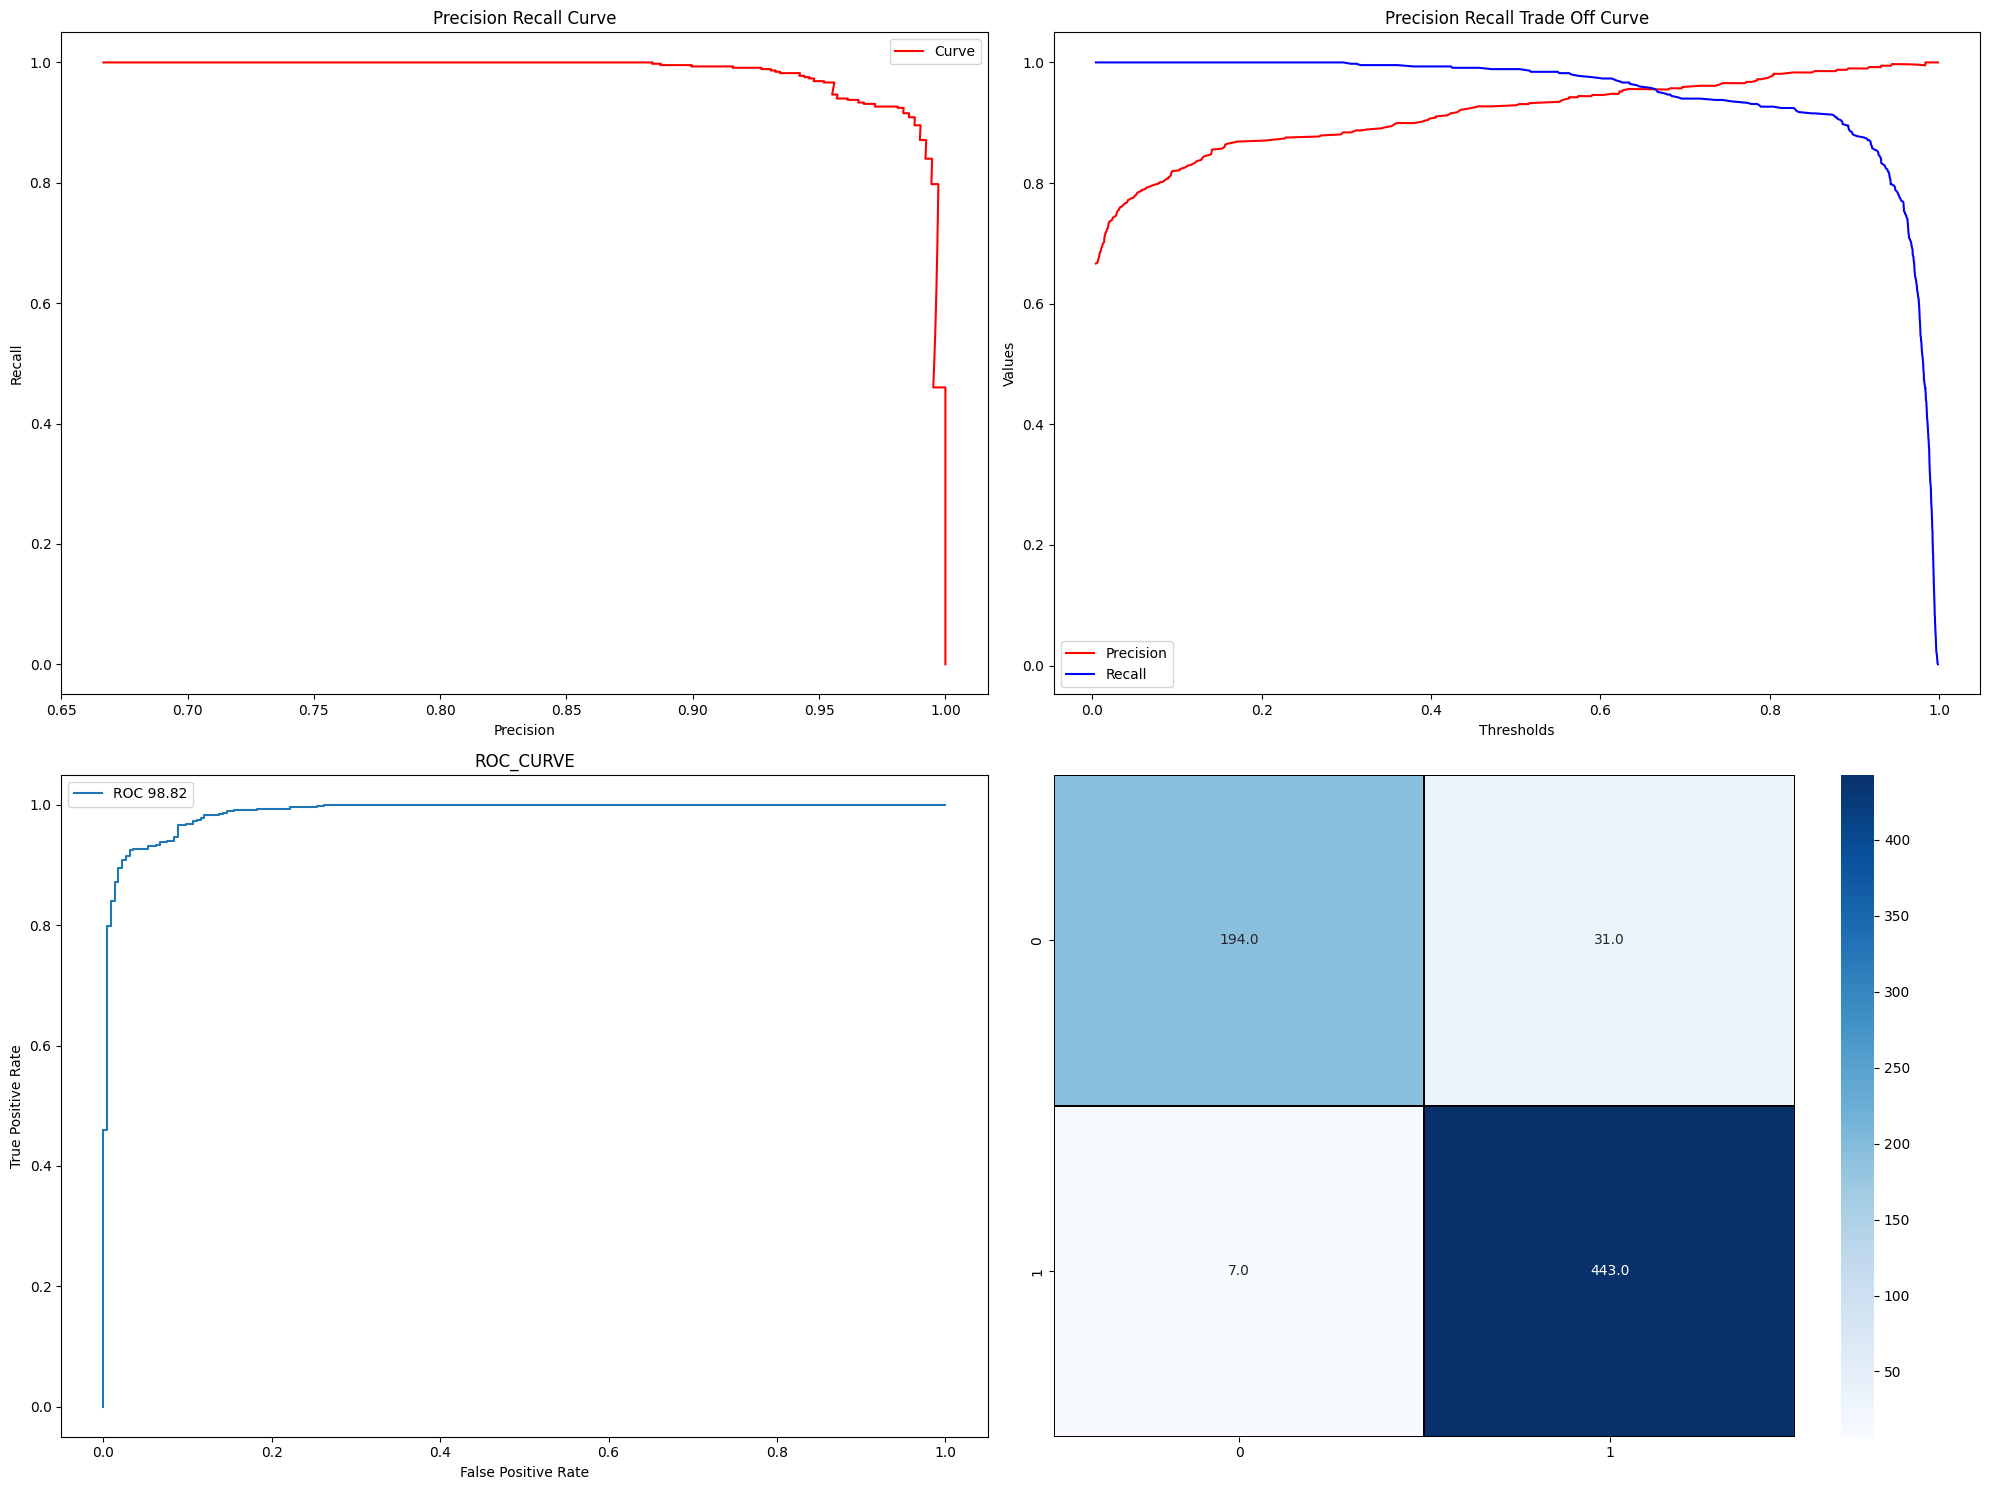

              precision    recall  f1-score   support

           0       0.97      0.86      0.91       225
           1       0.93      0.98      0.96       450

    accuracy                           0.94       675
   macro avg       0.95      0.92      0.93       675
weighted avg       0.94      0.94      0.94       675

---MODEL TRAINING STARTED---


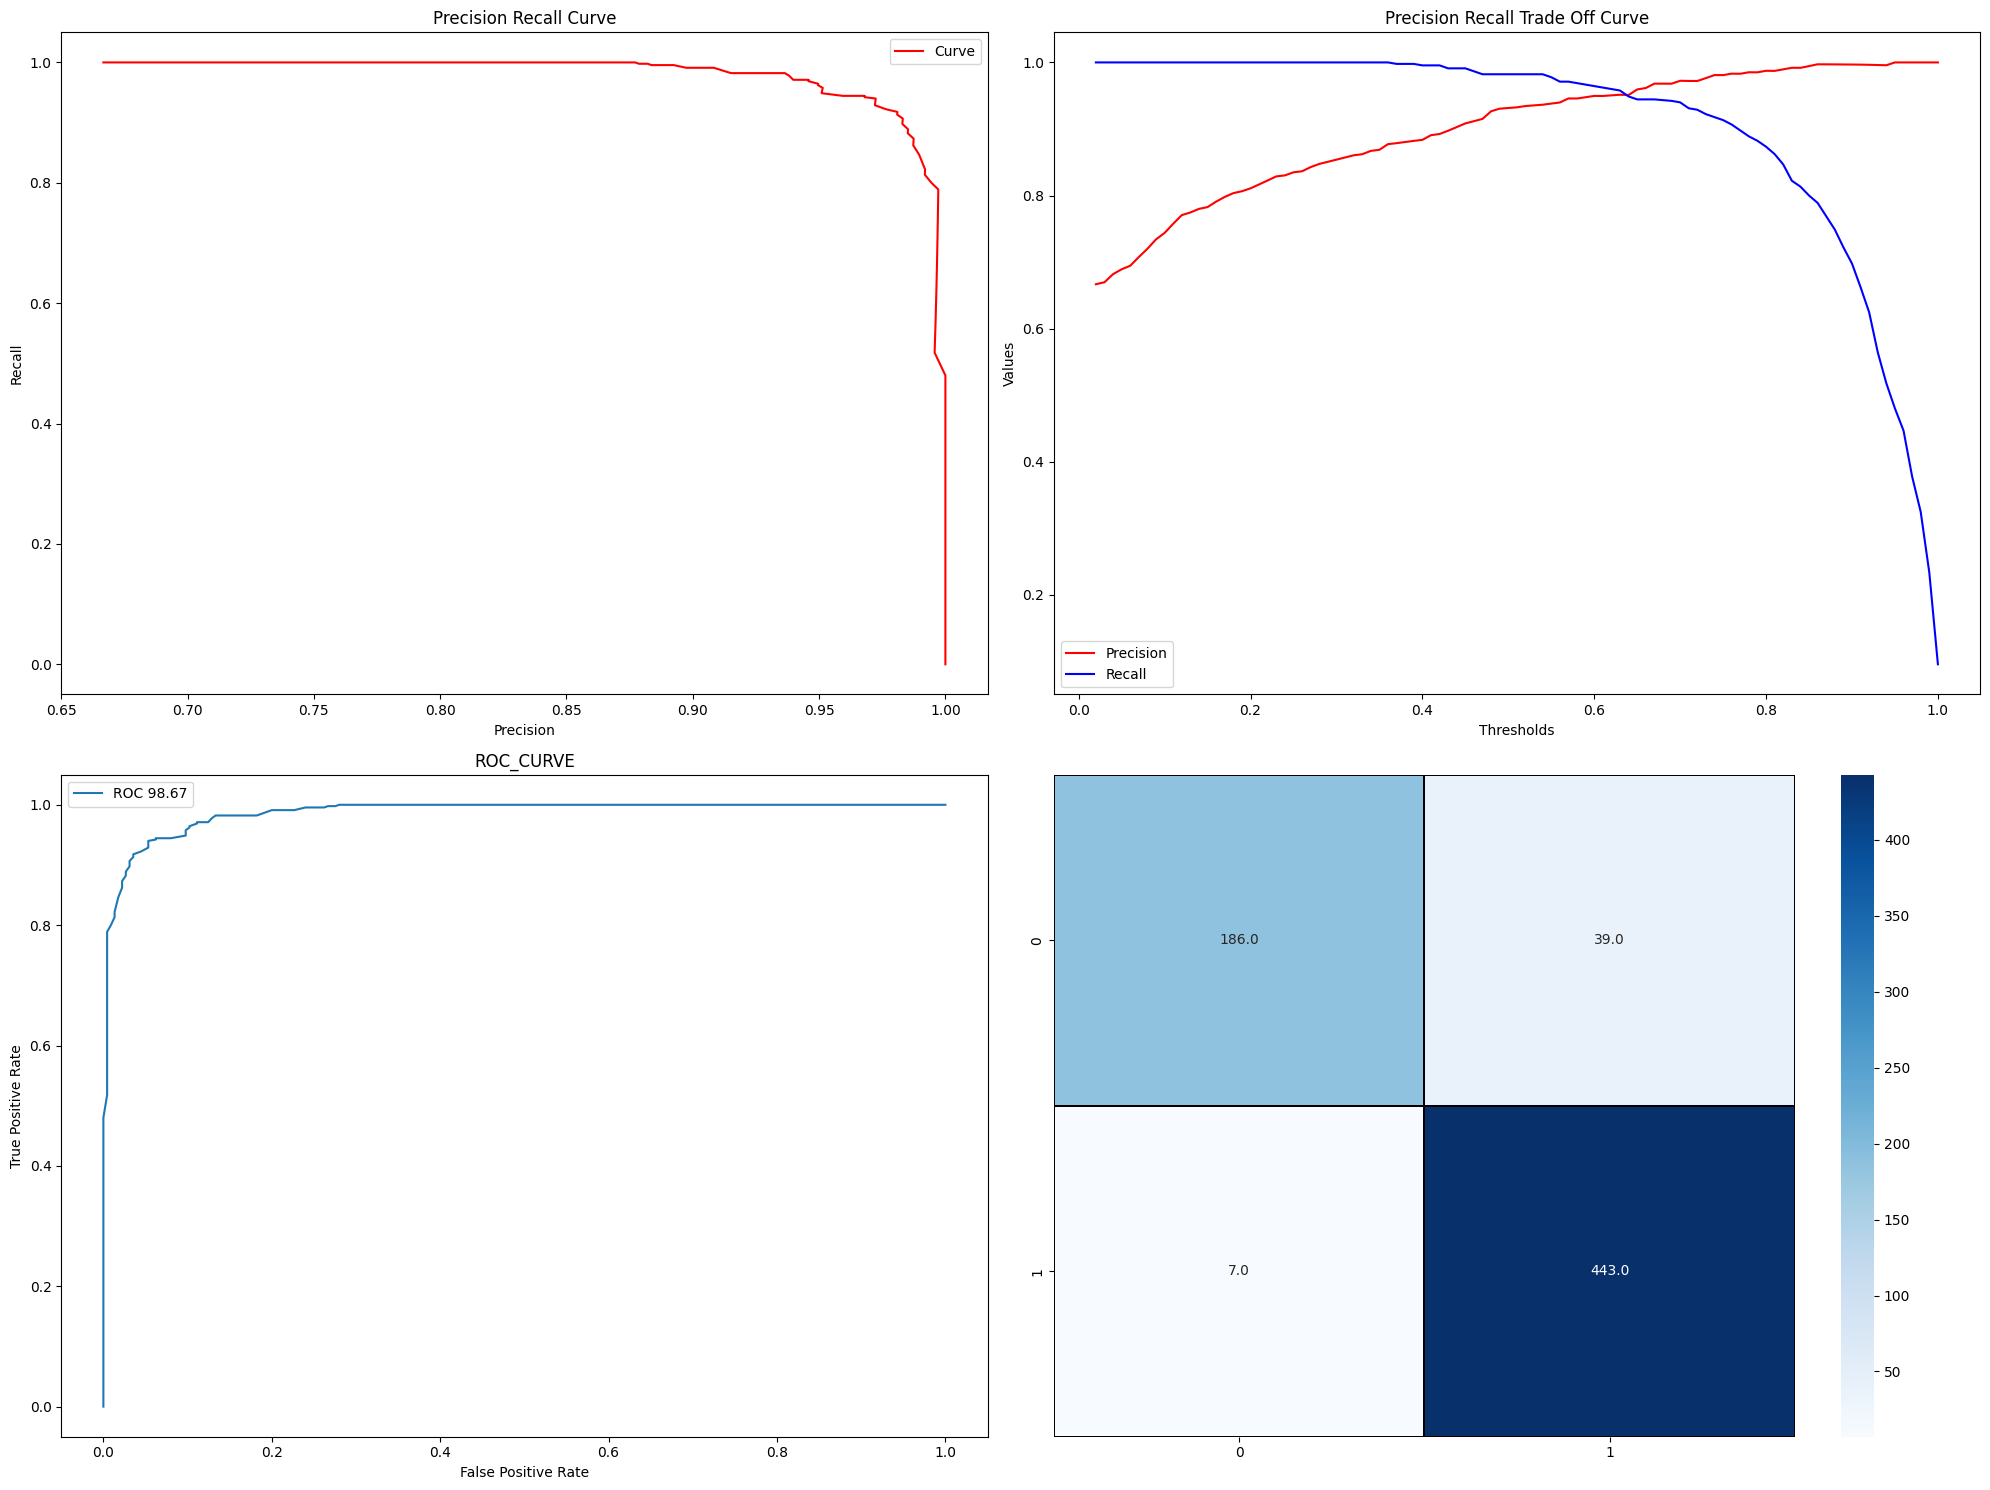

              precision    recall  f1-score   support

           0       0.96      0.83      0.89       225
           1       0.92      0.98      0.95       450

    accuracy                           0.93       675
   macro avg       0.94      0.91      0.92       675
weighted avg       0.93      0.93      0.93       675

---MODEL TRAINING STARTED---


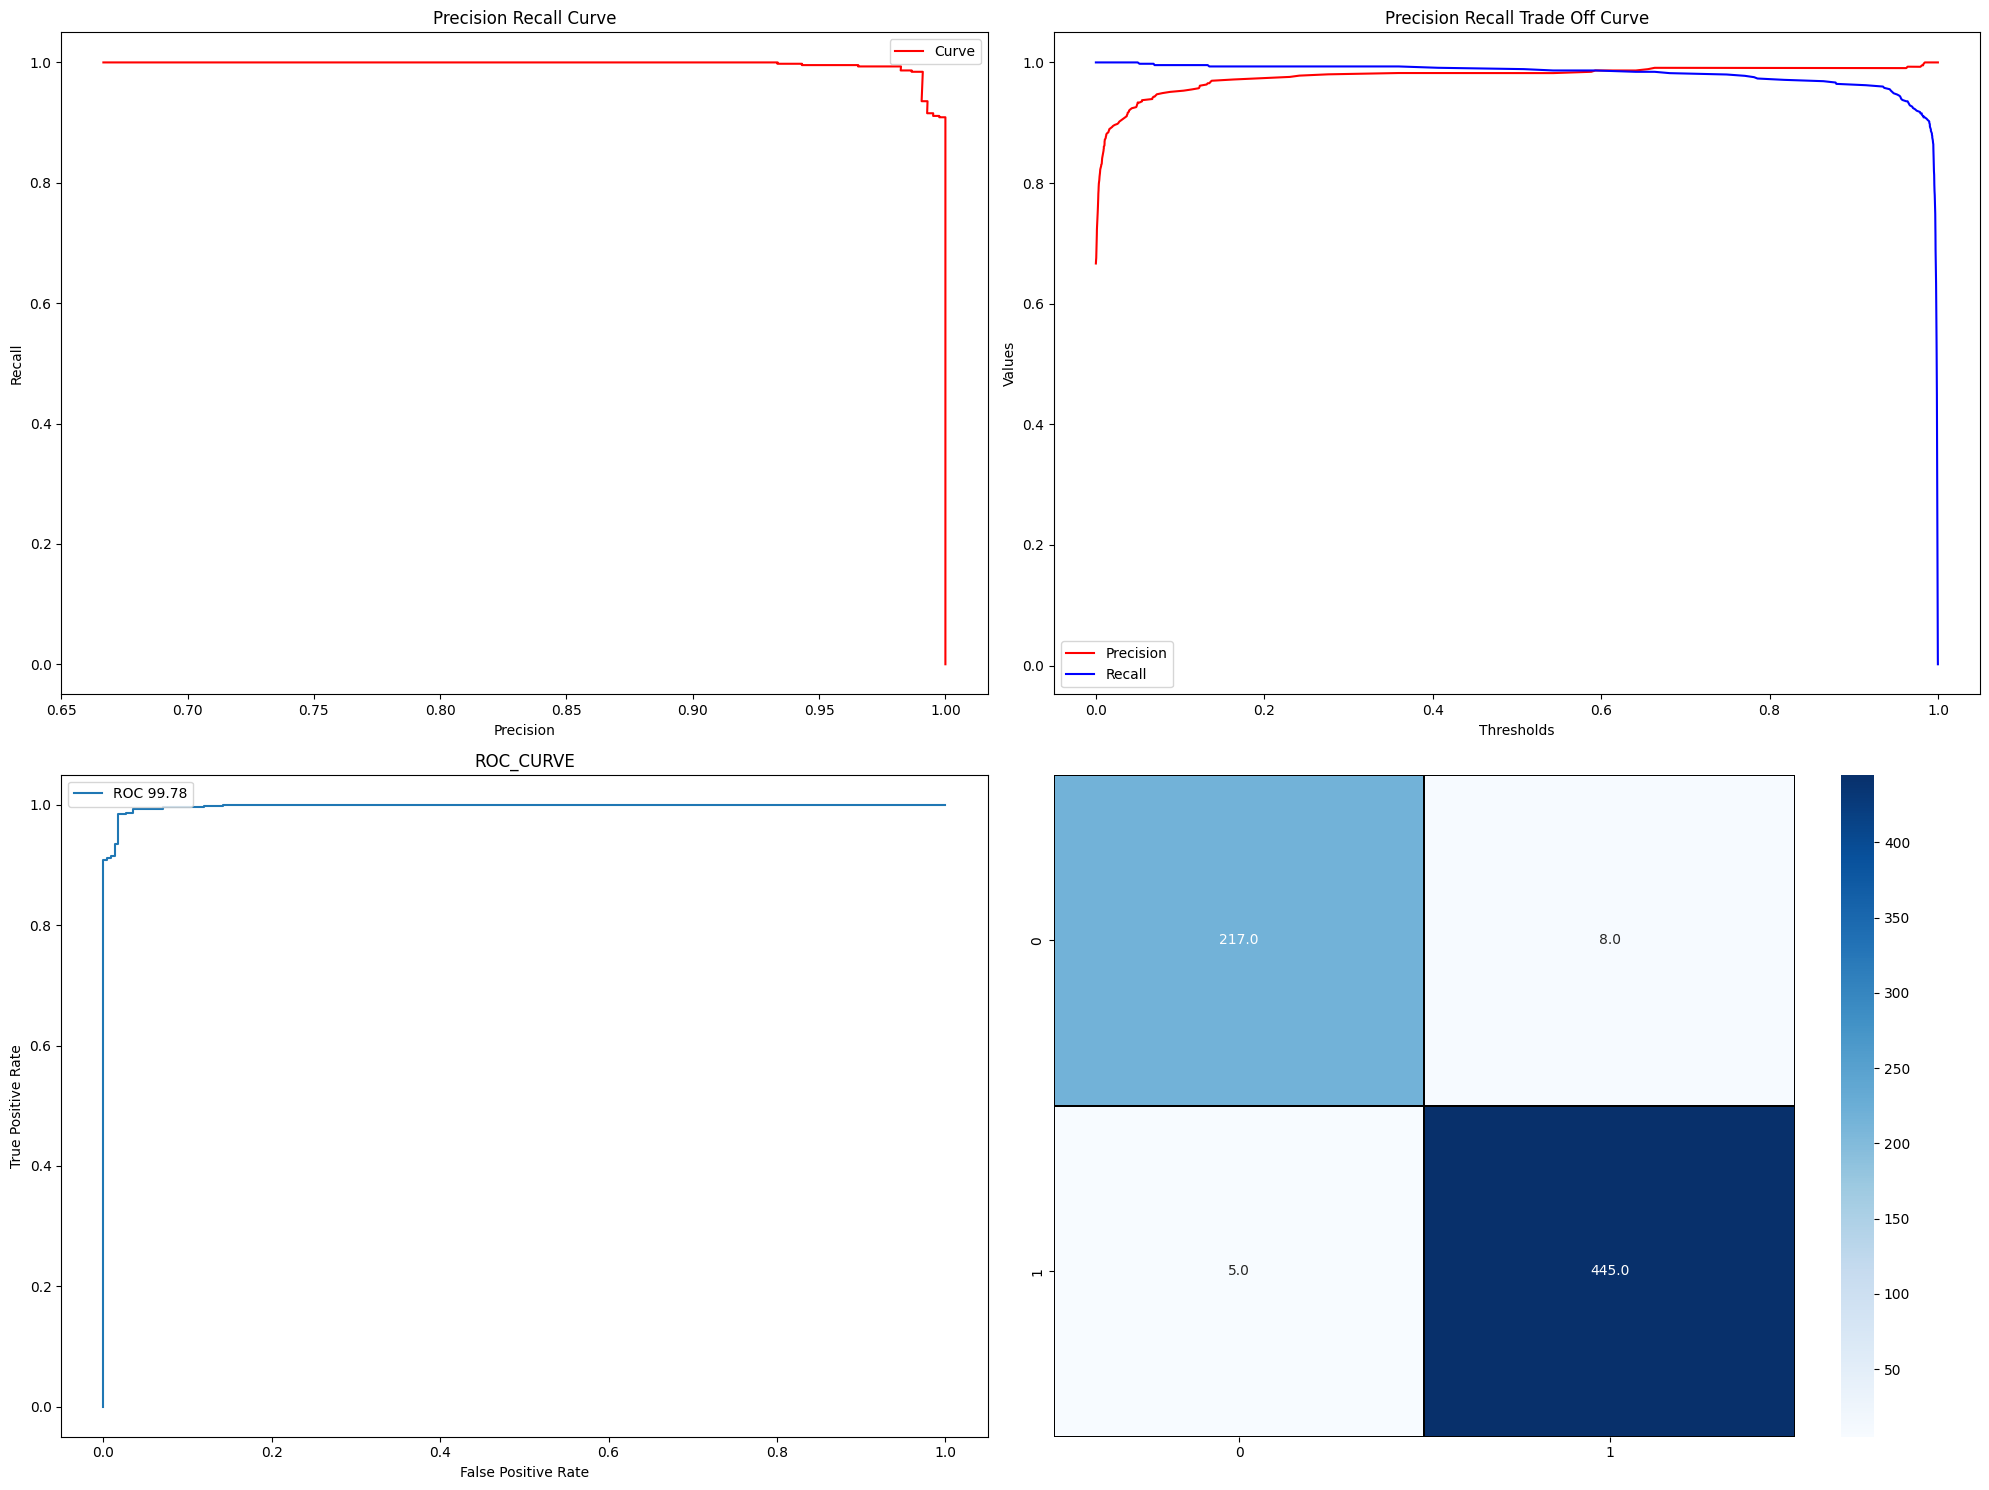

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       225
           1       0.98      0.99      0.99       450

    accuracy                           0.98       675
   macro avg       0.98      0.98      0.98       675
weighted avg       0.98      0.98      0.98       675



In [ ]:
for model in models:
    print("---MODEL TRAINING STARTED---")
    res=evaluator(model,X_train_prep,y_train)
    result.append(res)
    print("="*50)

In [ ]:
overall=pd.concat([result[0],result[1],result[2]])
overall

,Acc,Prec,Rec,F1,AUC
SGDClassifier,94.37,93.46,98.44,95.89,98.82
RandomForestClassifier,93.19,91.91,98.44,95.06,98.67
XGBClassifier,98.07,98.23,98.89,98.56,99.78


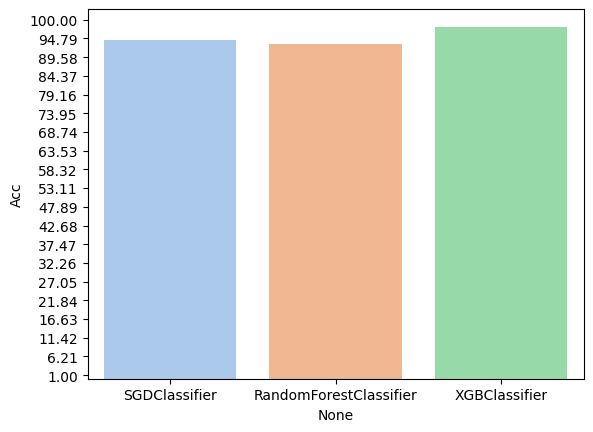

In [ ]:
sns.barplot(x=overall.index,y=overall.Acc,palette="pastel")
plt.yticks(np.linspace(1,100,20))
plt.show()

# Hyperpparameter tuning

In [ ]:
def objective(trail):
    params={"n_estimators":trail.suggest_int("n_estimators",100,600),
           "max_depth":trail.suggest_int("max_depth",2,10),
           "learning_rate":trail.suggest_float("learning_rate",0.01,0.15),
           "subsample":trail.suggest_float("subsample",0.5,1.0),
           "min_child_weight":trail.suggest_int("min_child_weight",5,20)}

    model=XGBClassifier(**params)

    cv=StratifiedKFold(n_splits=3,random_state=42,shuffle=True)
    accuracy=cross_val_score(model,X_train_prep,y_train,cv=cv,scoring="accuracy")

    return accuracy.mean()

In [ ]:
study=optuna.create_study(direction="maximize")
study.optimize(objective,n_trials=10,show_progress_bar=True)

[I 2026-02-13 13:36:37,388] A new study created in memory with name: no-name-2d6d3ccc-95b7-40c4-ac6b-9d99e4ecbafd


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2026-02-13 13:36:48,468] Trial 0 finished with value: 0.954074074074074 and parameters: {'n_estimators': 563, 'max_depth': 8, 'learning_rate': 0.07543139535964698, 'subsample': 0.5317018821123793, 'min_child_weight': 5}. Best is trial 0 with value: 0.954074074074074.
[I 2026-02-13 13:36:53,224] Trial 1 finished with value: 0.9333333333333332 and parameters: {'n_estimators': 390, 'max_depth': 7, 'learning_rate': 0.13596250082704198, 'subsample': 0.6798733992370963, 'min_child_weight': 18}. Best is trial 0 with value: 0.954074074074074.
[I 2026-02-13 13:37:00,009] Trial 2 finished with value: 0.954074074074074 and parameters: {'n_estimators': 374, 'max_depth': 7, 'learning_rate': 0.12697396528703223, 'subsample': 0.5891922539160762, 'min_child_weight': 5}. Best is trial 0 with value: 0.954074074074074.
[I 2026-02-13 13:37:08,797] Trial 3 finished with value: 0.9274074074074073 and parameters: {'n_estimators': 535, 'max_depth': 4, 'learning_rate': 0.11964940727645923, 'subsample': 0.60

In [ ]:
print("Best Params:", study.best_params)
print("Best CV Score:", study.best_value)

Best Params: {'n_estimators': 598, 'max_depth': 8, 'learning_rate': 0.045071941105121714, 'subsample': 0.8024963965361691, 'min_child_weight': 5}
Best CV Score: 0.96


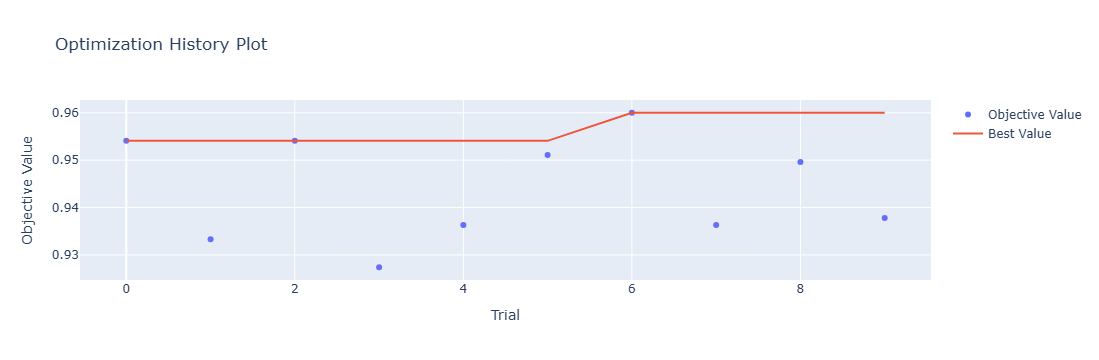

In [ ]:
plot_optimization_history(study).show()

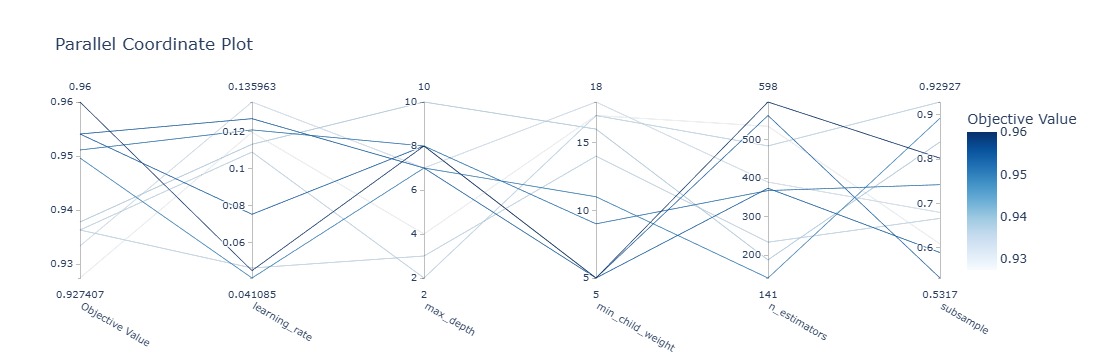

In [ ]:
plot_parallel_coordinate(study).show()

In [ ]:
plot_slice(study).show()

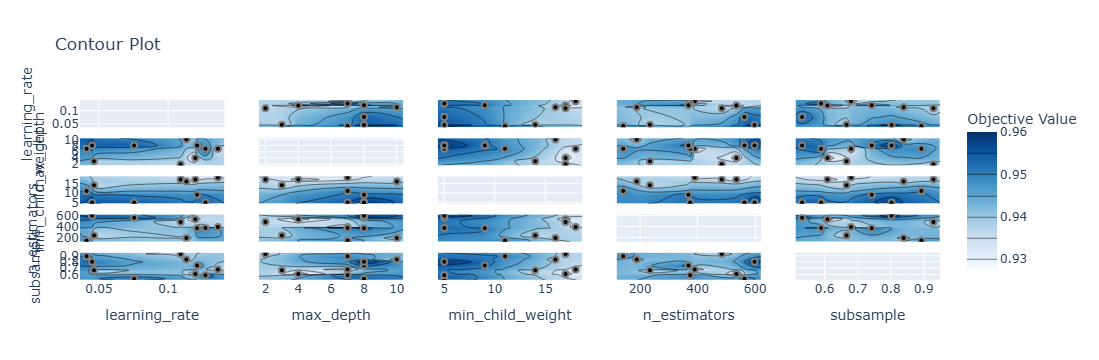

In [ ]:
plot_contour(study).show()

In [ ]:
plot_param_importances(study).show()

# Final Fucntions

In [ ]:
def final_evaluator(model,feature,target):
    
    predictions=model.predict(feature)
    score=model.predict_proba(feature)[:,1]
    
    Dict={"Acc":None,"Prec":None,"Rec":None,"F1":None,"AUC":None}
    Dict["Acc"]=round(accuracy_score(target,predictions)*100,2)
    Dict["Prec"]=round(precision_score(target,predictions)*100,2)
    Dict["Rec"]=round(recall_score(target,predictions)*100,2)
    Dict["F1"]=round(f1_score(target,predictions)*100,2)
    cnf_mat=confusion_matrix(target,predictions)
    clf_report=classification_report(target,predictions)
    Dict["AUC"]=round(roc_auc_score(target,score)*100,2)
    
    Data=pd.DataFrame(Dict,index=[model.__class__.__name__])

    fig,ax=plt.subplots(2,2,figsize=(20,15))

    prec,rec,thres=precision_recall_curve(target,score)
    fpr,tpr,threshols=roc_curve(target,score)

    ax[0][0].plot(prec,rec,color="red",label="Curve")
    ax[0][0].set_title("Precision Recall Curve")
    ax[0][0].set_xlabel("Precision")
    ax[0][0].set_ylabel("Recall")
    ax[0][0].legend()

    ax[0][1].plot(thres,prec[:-1],label="Precision",color="red")
    ax[0][1].plot(thres,rec[:-1],label="Recall",color="blue")
    ax[0][1].set_title("Precision Recall Trade Off Curve")
    ax[0][1].set_xlabel("Thresholds")
    ax[0][1].set_ylabel("Values")
    ax[0][1].legend()
    

    ax[1][0].plot(fpr,tpr,label=f"ROC {Dict["AUC"]}")
    ax[1][0].set_title("ROC_CURVE")
    ax[1][0].set_xlabel("False Positive Rate")
    ax[1][0].set_ylabel("True Positive Rate")
    ax[1][0].legend()
    

    sns.heatmap(cnf_mat,annot=True,fmt="0.1f",linewidths=0.2,linecolor="black",cmap="Blues",ax=ax[1][1])

    plt.tight_layout()
    plt.show()
    print(clf_report)
    return Data

In [ ]:
param_grid=study.best_params

In [ ]:
Final_Model=XGBClassifier(**param_grid)

In [ ]:
Final_Model.fit(X_train_prep,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.045071941105121714, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=598, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
joblib.dump(Final_Model,"Spam_classifier.pkl")

['Spam_classifier.pkl']

In [ ]:
joblib.dump(vectorizer,"Spam_vectorizer.pkl")

['Spam_vectorizer.pkl']